In [55]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict

In [241]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': 0,
            'time': 0
        }
        self.done = False
        return self.state
        
    def step(self, action):
        loaded = self.actions.get(action)
        reward = 0
        if loaded + self.state['level'] > self.cap: #Charging would exceed the total capacity of the battery
            reward -= cost_func(self.state['time'], self.cap - self.state['level'])
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded
        
        self.state['time'] += 1
        
        if self.state['time'] == 8:
            if self.state['level'] - power_consumed() >= 0:
                self.reset()
            else:
                self.reset()
                reward += self.stuck_penalty  # Add the stuck penalty directly to the reward
            self.done = True
                
        return self.state, reward, self.done, {}  # Updated the return statement with four values as expected by the Gym environment
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [1, 1, 1, 1, 1, 1, 1, 1]
    return alpha_time[t] * exp(p)

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

def plot_q_values(q_table,cap):
    
    def get_Z(key):
        #return max(q_table[key])
        return np.average(q_table[key])
        
    # battery level
    X = np.arange(cap +1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # max q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y,X)]).reshape((8,cap_max+1))

    fig = plt.figure(figsize=(10, 10))

    # Add a 3D subplot
    #ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1, 4)]
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('max Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Batterie level')
    plt.tight_layout()
    plt.show()


## Agents

In [243]:
class MC_agent():
    def __init__(self, alpha, env, epsilon, epsilon_decay, epsilon_min): 
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if state_key in self.q_table:
            action_q_values = self.q_table[state_key] 
            return self.epsilon_greedy(action_q_values)
        else:
            return self.env.action_space.sample()
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size) 

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, goal):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        
        self.q_table_count[state_key][action] += 1
        learning_rate = self.alpha / self.q_table_count[state_key][action]
        self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        
    def train(self,iterations):
        for i in range(iterations):
            state = self.env.reset()
            episode = []
            done = False

            while not done:
                action = self.pick_action(state)
                old_state = state.copy()
                state, reward, done, _= self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode):
                goal += reward
                self.update_q_values(state, action, goal)
        return self.q_table

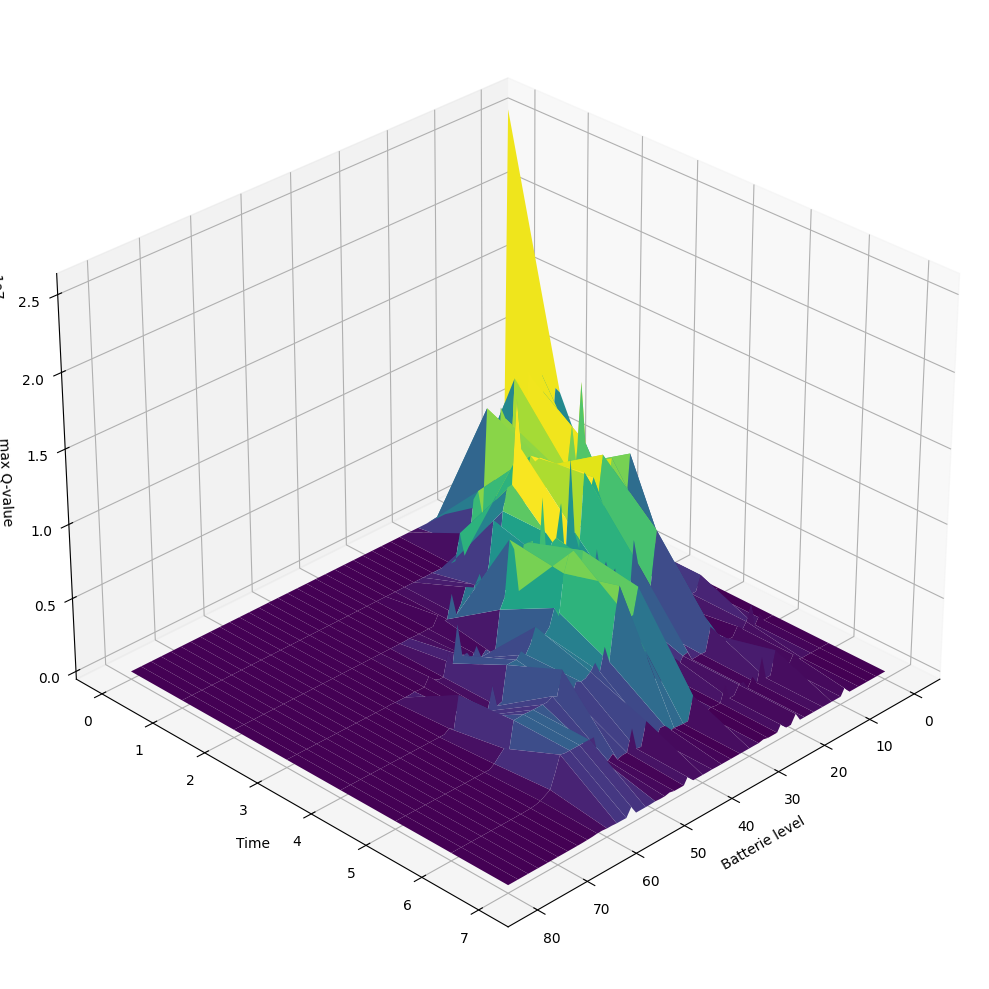

In [242]:
actions = {i: i for i in range(23)}

env = SmartCharging(actions=actions, cap=80, stuck_penalty=-5000)

agent = MC_agent(alpha=0.01, env=env, epsilon=0.1, epsilon_decay=0.9, epsilon_min=0.01)

plot_q_values(agent.train(1000),env.cap)

Monte Carlo, Q-learning (double) , Deep Q-Network, SARSA